# <span style="background-color:#fff5b1"><span style="color:black"><B>보험사 마케팅 활용을 위한 고객 군집화 모델링

## **Mission 3. 분석 모델 개발**

### [미션 이해하기]
* 여러분들은 K 보험사의 직원입니다. K보험사는 효과적인 마케팅 전략을 완성시키기 위해 데이터 기반 마케팅을 시작했습니다.
  <br>고객의 행동,성향, 니즈 등의 고객 데이터를 마케팅 전략에 반영하여 고객별로 적절한 마케팅 Action을 주는 미션을 받았습니다.
* 고객별로 특징을 적절하게 반영할 수 있는 마케팅 방안은 고객을 segment 하는 것 인데, 어떤 방법으로 고객을 묶을 수 있을까요?
  <br>바로, <font color="1E90FF"><b>군집분석을 기반으로 한 고객 segment를 개발 하는 것입니다.</font>


<b>[2일차] mission 3 목표<b>: 전처리 한 데이터를 활용하여 군집분석 하고, 데이터 탐색 기반 프로파일링을 통해 군집별 특징 정의 해보기

---------------------------------------------------------------------------------------------
# **0. 환경설정(경로설정)**
* 세부 요구사항
    - 경로 설정 : 구글 colab
        * 구글 드라이브 바로 밑에 dxproject 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.

In [ ]:
from google.colab import drive
drive.flush_and_unmount()

Drive not mounted, so nothing to flush and unmount.


In [ ]:
# 구글 드라이브 연결
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/4주차(4 14~4 18)/DX_미니프로젝트 1차_1-2일차_실습자료
!ls

/content/drive/MyDrive/4주차(4 14~4 18)/DX_미니프로젝트 1차_1-2일차_실습자료
'1. 데이터분석.ipynb'	  data_sc.csv
'2. 데이터전처리.ipynb'  'DX 미프1차_OO반_OO조(마케팅전략 양식).pptx'
'3. 군집 분석.ipynb'	  result.csv
 customers_seg.csv


In [ ]:
#Path
path = '1/content/drive/MyDrive/4주차(4 14~4 18)/DX_미니프로젝트 1차_1-2일차_실습자료'

---------------------------------------------------------------------------------------------
#### <b>[실습프로세스]<b>

1. k-means 군집분석
2. 프로파일링

---------------------------------------------------------------------------------------------
# **1. k-means 모델(군집 분석)**

**k-means 모델이란?**
 > **비지도학습의 대표적인 군집분석을 위한 모델로 주어진 데이터를 K개의 클러스터로 묶는 알고리즘**
 > * K 군집의 초기 중심에서 시작해서 중심을 바꾸는 단계를 사용하여 데이터를 가장 가까운 군집으로 포함시켜 분류하는 모델
 > * 장점: 단순 알고리즘 및 빠른 연산 속도
 > * 단점: 이상치, 노이즈에 민감하고 초기 군집 수 결정 단계가 필요함

## **(1) 데이터 불러오기**

In [ ]:
# 필요 라이브러리 로딩

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# mosaic
from statsmodels.graphics.mosaicplot import mosaic

import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
# 한글 세팅

# 1. 나눔고딕 폰트 설치
!apt-get -qq update
!apt-get -qq install -y fonts-nanum

# 2. 런타임에 폰트 캐시 갱신
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib as mpl

font_dirs = ['/usr/share/fonts/truetype/nanum']
font_files = fm.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    fm.fontManager.addfont(font_file)

# 3. 폰트 이름 확인 후 설정
nanum_font_name = fm.FontProperties(fname=font_files[0]).get_name()
print(f"설정된 폰트 이름: {nanum_font_name}")

# matplotlib에 폰트 반영
mpl.rc('font', family=nanum_font_name)
mpl.rcParams['axes.unicode_minus'] = False

# 지수표현(소수점 2자리까지 나타내기)
pd.options.display.float_format = '{:.2f}'.format

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
설정된 폰트 이름: NanumGothicCoding


In [ ]:
# [문제 1~2] 스케일링 한 데이터 불러오기
# 1. data 변수에 'data_sc.csv' 파일을 불러와서 할당
# 2. data 변수 호출해서 상위 5개 확인해보기

data = pd.read_csv('data_sc.csv')
data.head(5)
col = ['AGE', '고용상태', 'Willingness to pay/Stay', '상품타입','교육수준', '소득', '월 납입액','타 상품 보유 현황', '총지불금액', '거주지사이즈','자동차']

## **(2) 군집분석**

<b>군집분석을 위해 최적의 그룹 k 값을 찾아보고 최적의 군집 수를 결정해 보자

### <b>**1) 기본 셋팅**
* yellowbrick을 임포트 해서 군집분석 해보기

In [ ]:
#[같이 하기] yellowbrick이 없는 경우 pip로 설치해 주기(!pip install yellowbrick)

!pip install yellowbrick

In [ ]:
# [같이 하기] k-means, yellowbrick의 KElbowVisualizer 불러오기

from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

### <b>**2) 직접 하나하나 해보기**
* 몇 개의 그룹으로 군집화를 할지 k 값을 바꿔 가면서 '최적의 k 값'을 찾아보는 것을 해보자.

In [ ]:
# [같이 하기] 군집화할 그룹(k) 결정하기

# 우리는 먼저 몇개의 그룹으로 군집화 할지 3~10까지 수 중에서 결정하려고 3부터 2씩 올려서 클러스터링을 해보려고 한다.
# 그러면 3개의 그룹부터 시작해 보자.


# 1.몇개의 그룹(k)으로 군집화 할지 임의로 정해보기(k에 할당)
k=3

# 2. 모델 만들기 (그룹수 : n_clusters 파라미터 사용)
# 동일값을 위해 random_state=2024, n_init=10으로 설정값을 같이 해본다.
# [참고]n_init 지정 : warning을 없애기 위해 지정해준다.

model_1 = KMeans(n_clusters=k, random_state=2025,n_init=10)

#3. 스케일링 된 데이터에 학습

model_1.fit(data)


KMeans(n_clusters=3, n_init=10, random_state=2025)

In [ ]:
# [같이 하기] 모델이 찾은 3개의 센트로이드를 확인해보자.
# 센트로이드는 하나의 클러스터(k) 내 데이터의 중심이 되는 점이다.

model_1.cluster_centers_

# a = pd.DataFrame(model_1.cluster_centers_, columns=col)
# display(a)
'''
 각 array안의 각 꺽쇠는 클러스터를 의미함. 우리는 클러스터를 3으로 해줬기 때문에
 [] , [] , [] 가 되는 것임.
 그 안에는 11개의 feature가 있는 것이고 각각 중심점을 의미함.
 그리고 스케일링을 standard로 해주었기 때문에 값은 0과 1사이를 갖고
 이 표를 보고 해석할 땐 0.488... 으로 나온 age는 평균보다 조금 많다. 이런식으로 해석을 해줌.

 만약 min-max 스케일러로 해줬다면 각 컬럼 값들을 0과 1사이로 스케일링해주기 때문에
 해석할 땐 그냥 큰 값, 작은 값으로해ㅐ준다.
'''


'\n 각 array안의 각 꺽쇠는 클러스터를 의미함. 우리는 클러스터를 3으로 해줬기 때문에\n [] , [] , [] 가 되는 것임.\n 그 안에는 11개의 feature가 있는 것이고 각각 중심점을 의미함.\n 그리고 스케일링을 standard로 해주었기 때문에 값은 0과 1사이를 갖고\n 이 표를 보고 해석할 땐 0.488... 으로 나온 age는 평균보다 조금 많다. 이런식으로 해석을 해줌.\n\n 만약 min-max 스케일러로 해줬다면 각 컬럼 값들을 0과 1사이로 스케일링해주기 때문에\n 해석할 땐 그냥 큰 값, 작은 값으로해ㅐ준다.\n'

#### (여러분들을 위한 tip)
- Kmeans객체는 각 군집을 구성하는 단어 피처가 군집의 중심(Centroid)을 기준으로 얼마나 가깝게 위치해 있는지 cluster_centers_라는 속성으로 제공합니다.
- 3개의 클러스터에 각 군집 중심점의 좌표를 확인할 수 있습니다.
- cluster_centers_는 배열 값으로 제공되며, 행은 개별 군집을, 열은 개별 피처를 의미합니다.
- 각 배열 내의 값은 개별 군집 내의 상대 위치를 숫자 값으로 표현한 일종의 좌표 값입니다. 예를 들어 cluster_centers[0,1]은 0번 군집에서 두 번째 피처의 위치 값입니다.

In [ ]:
# [같이 하기] 3가지 성능지표를 통해서 확인해보기

# 1. inertia(이너셔) : 각 데이터와 센트로이드(중심) 사이의 평균 제곱거리로 도출한 모델 (model.inertia_로 쓴다)
# 2. score 매서드: 이너셔의 음수값을 반환( model.score(df))

print(model_1.inertia_)
print(model_1.score(data))

93559.51847749663
-93559.51847749663


#### (여러분들을 위한 tip)
- KMeans 클래스는 n_init번 실행하여 이너셔가 가장 낮은 모델을 리턴합니다.
- 하지만 마냥 이니셔가 낮다고 좋은 모델일까요?
- k가 늘어날 수록 이너셔는 점점 작아지기 때문에 이너셔가 그다지 좋은 성능 지표가 아니라는 걸 알 수 있습니다.
- 어차피 클러스터가 늘어날 수록 각각의 데이터는 가까운 센트로이드에 가까워지기 때문에 이너셔가 작아지는 건 당연한 결과입니다.
- 그걸 파악하기 위해서 한번 k값에 따라 이니셔가 어떻게 변하는지 확인해 보시죠.

<b> k=3을 같이 해봤으니 이제 여러분들이 한번 그룹수(k)를 바꿔가면서 판단을 해보실 차례입니다!
<br>2씩 늘려가면서 k값을 5,7,9개의 그룹으로 나눠서 모델 학습 시키고 성능지표를 확인해 보세요!

In [ ]:
#[문제 3] 군집화할 그룹(k)을 5개로 해보자.

# 1.몇개의 그룹(k)으로 군집화 할지 임의로 정해보기(k1에 할당)
k1=5

# 2. 모델 만들기 (그룹수 : n_clusters 파라미터 사용) (model_2 에 할당)
# 동일값을 위해 random_state=2025, n_init=10으로 설정값을 같이 해본다.
# [참고]n_init 지정 : warning을 없애기 위해 지정해준다.

model_2 = KMeans(n_clusters=k1, random_state=2025,n_init=10)

#3. 스케일링 된 데이터에 학습
model_2.fit(data)


#4. 학습한 결과 inertia,score 로 확인 해보기
print(model_2.inertia_)
print(model_2.score(data))


74062.2921667622
-74062.2921667622


In [ ]:
#[문제 4] 군집화할 그룹(k)을 7개로 해보자.

# 1.몇개의 그룹(k)으로 군집화 할지 임의로 정해보기(k2에 할당)

k2=7

# 2. 모델 만들기 (그룹수 : n_clusters 파라미터 사용) (model_3 에 할당)
# 동일값을 위해 random_state=2025, n_init=10으로 설정값을 같이 해본다.
# [참고]n_init 지정 : warning을 없애기 위해 지정해준다.

model_3 =KMeans(n_clusters=k2, random_state=2025,n_init=10)

#3. 스케일링 된 데이터에 학습

model_3.fit(data)

#4. 학습한 결과 inertia,score 로 확인 해보기
print(model_3.inertia_)
print(model_3.score(data))


60258.67316591424
-60258.67316591424


In [ ]:
#[문제 5] 군집화할 그룹(k)을 9개로 해보자.

# 1.몇개의 그룹(k)으로 군집화 할지 임의로 정해보기(k3에 할당)

k3=9

# 2. 모델 만들기 (그룹수 : n_clusters 파라미터 사용) (model_4 에 할당)
# 동일값을 위해 random_state=2025, n_init=10으로 설정값을 같이 해본다.
# [참고]n_init 지정 : warning을 없애기 위해 지정해준다.

model_4 =KMeans(n_clusters=k3, random_state=2025,n_init=10)

#3. 스케일링 된 데이터에 학습

model_4.fit(data)

#4. 학습한 결과 inertia,score 로 확인 해보기
print(model_4.inertia_)
print(model_4.score(data))

54309.68319625138
-54309.68319625138


-----------

* <b>for 문을 활용해서 그래프로도 확인을 해볼까요?

n_cluster:2, inertia:110876.94724020964
---------
n_cluster:3, inertia:93559.78490326648
---------
n_cluster:4, inertia:83454.74686785738
---------
n_cluster:5, inertia:74062.35837047185
---------
n_cluster:6, inertia:66746.73588210318
---------
n_cluster:7, inertia:60333.942343134375
---------
n_cluster:8, inertia:56886.224100598614
---------
n_cluster:9, inertia:54169.621320580234
---------
n_cluster:10, inertia:51217.32068028046
---------
n_cluster:11, inertia:49740.86843832207
---------
n_cluster:12, inertia:46654.38464806841
---------
n_cluster:13, inertia:45316.36284490268
---------
n_cluster:14, inertia:43559.042423152794
---------
n_cluster:15, inertia:42254.7127016808
---------
n_cluster:16, inertia:41214.36533737347
---------
n_cluster:17, inertia:39796.14625886147
---------
n_cluster:18, inertia:38619.18111237359
---------
n_cluster:19, inertia:37648.95523124486
---------
n_cluster:20, inertia:36917.18873845023
---------


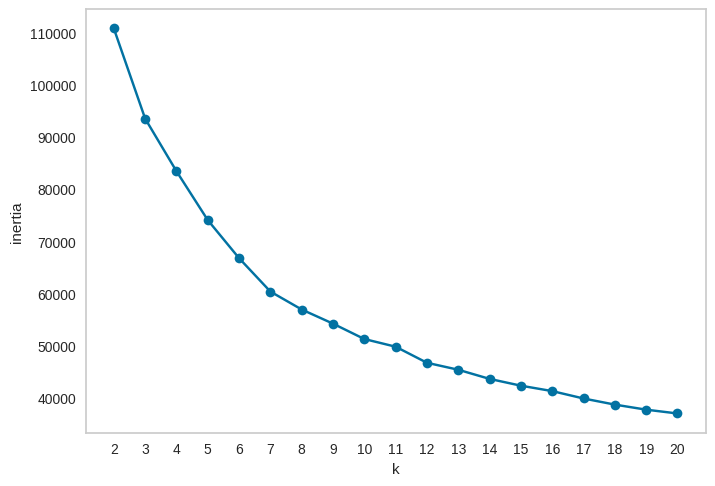

In [ ]:
#[문제 6] for 문을 활용해서 2~20까지 k값을 넣어서 성능지표 확인하기

ks= range(2,21)         # k값 범위 지정(range(2,21)) 후 ks 변수에 할당
inertias = []  # 이너셔 결과를 저장하기 위한 빈 리스트 생성 (변수명 inertias)

for k in ks  : # for문 활용
    model_for = KMeans(n_clusters = k, n_init = 10)           # k-means 모델 만들기(그룹수 : n_clusters 파라미터 사용,n_init=10)
    model_for.fit(data)                                          # 모델 학습
    inertias.append(model_for.inertia_)                    # 이너셔 결과를 inertias 리스트에 계속 저장(append 활용)
    print('n_cluster:{}, inertia:{}'.format(k, model_for.inertia_))
    print('---------') # n_cluster, inertia 결과 출력


plt.Figure(figsize=(15,6))
plt.plot(ks,inertias,'-o') # '-o'는 실선과 원을 같이 시각화
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.grid()
plt.show()

여기서는 확실하게 어떤 k 값이 좋은지 파악하기가 힘들긴 하네요

### <b>**3) [참조]Elbow Method 활용해서 k 값 구하기**
* yellowbrick의 k-Elbow Mehod를 활용해서 최적의 k 값을 구하기(k값 결정하기 쉽게 도와주는 함수)

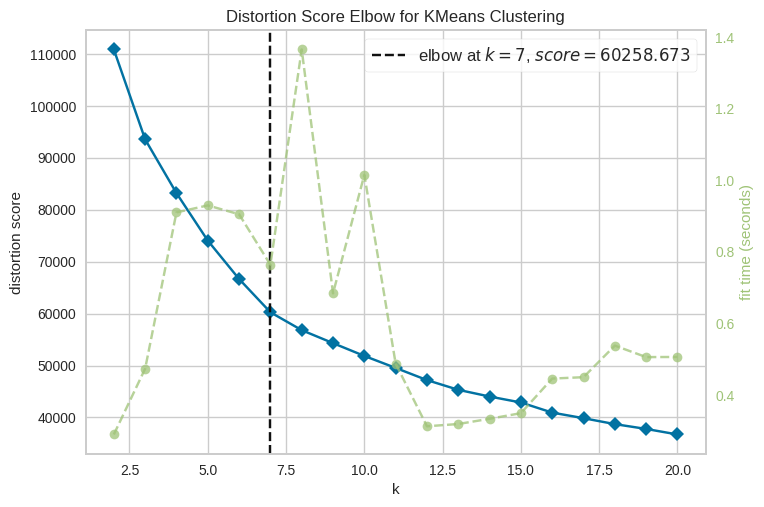

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
#[문제 7] Elbow Method를 통해 최적의 군집 수 도출을 해보자.

# 1. 모델 선언하기(random_state=2025, n_init = 10 으로 설정)(model_E로 할당)
model_E = KMeans(random_state=2025,n_init=10)

# 2. KElbowVisualizer 에 k-means 모델과 k값 넣어서 만들기(Elbow_M 에 할당)
# k값은 k=(2,21)사이의 값중에서 찾는 것으로 넣으면 된다.


Elbow_M = KElbowVisualizer(model_E,k=range(2,21))

# 3. Elbow 모델 학습하기(fit)

Elbow_M.fit(data)

# 4. Elbow 모델 확인하기(show()활용)

Elbow_M.show()

### <b>**4) 최적의 k 값으로 모델링**
* Elbow Method를 통해 나온 최적의 k값으로 모델링을 해보자.

In [ ]:
# [문제 8] 원본 데이터('customers_seg.csv') 불러오기

# 1. scale이 안된 원본 data에 clust를 맵핑 시키기 위해 원본 데이터('customers_seg.csv')도 불러옵시다
# data0 라는 변수에 할당하기
data0 = pd.read_csv('customers_seg.csv')

# 2. 'CID'는 활용하지 않을 예정으로 삭제합니다.
data0 = data0.drop('CID',axis=1)
# data0.drop('CID', axis = 1, inplace = True)


# 3. 데이터 상위 5개 확인하기
data0.head()

,AGE,등록(계/피),고용상태,성별,Willingness to pay/Stay,갱신,상품타입,교육수준,소득,지역,결혼여부,월 납입액,VOC,타 상품 보유 현황,온라인방문빈도,갱신인센티브,판매채널,총지불금액,자동차,거주지사이즈
0,3,피보험자,무직,1,2.62,0,기본,대학졸업,0,도시근교,미혼,80,0,1,자주방문,없음,자사영업,631000,일반세단,소
1,1,계약자,고용,0,6.35,0,기본,고졸이하,102887400,시골,미혼,80,1,4이상,비방문,포인트,인터넷,54000,일반세단,중
2,2,계약자,휴직,0,4.97,0,기본,대학졸업,22159500,도시근교,기혼,60,0,4이상,비방문,할인,자사영업,362000,일반세단,중
3,5,계약자,고용,1,13.48,0,고급,고졸이하,51562500,도시근교,기혼,110,0,2,비방문,할인,자사영업,1264000,컴팩트카,대
4,4,계약자,고용,0,9.78,0,기본,석사,26820200,도시근교,기혼,120,0,3,비방문,없음,대리점,947000,SUV,중


In [ ]:
# [문제 9] 최적의 k 값으로 k-means 모델을 구성해보자.

#1.최적의 k 값으로 군집 수 선택 (k4에 할당)
k4=7

# 2. 모델 만들기 (그룹수 : n_clusters 파라미터 사용) (model_B 에 할당)
# 동일값을 위해 random_state=2025, n_init=10으로 설정값을 같이 해본다.
# [참고]n_init의 기본 값이 10 이나 warning을 없애기 위해 지정해준다.

model_B = KMeans(n_clusters=k4, random_state = 2025, n_init = 10)

#3. 스케일링 된 데이터에 학습
model_B.fit(data)


#4. 클러스터링 된 결과 각 데이터가 몇번째 그룹에 속하는지 확인 및 저장(.predict)

cluster = model_B.predict(data)

In [ ]:
# [문제 10] 예측결과와 원본 데이터 합치기

#1. 예측 결과를 데이터프레임으로 만들고

cluster = pd.DataFrame(cluster, columns = ['cluster'])


#2. 원본 데이터와 합쳐서, result로 저장 --> ()안에 작성해보기!

result = pd.concat([data0, cluster], axis = 1)

#3. 예측 결과는 카테고리 타입으로 변경
result['cluster'] = pd.Categorical(result['cluster'] )
result.head()

#4. 결과 저장 --> 코드 마무리!
result.to_csv('result.csv', index=False)


<b> 각 고객별로 군집 된 번호가 데이터 프레임에 생성한 것을 볼 수 있습니다! 다 왔습니다!

* 이제부터 조별 과제를 수행합니다.
    * 조 내에서 최적의 K값으로 군집을 수행한 결과(result)를 하나 선정해서
    * 모든 조원들이 동일한 데이터를 로딩하고
    * 프로파일링을 시작합니다.


---------------------------------------------------------------------------------------------
# **2. 프로파일링**

<b>프로파일링 이란?
> <b>군집의 구조와 내용을 분석하고 도메인 및 현업업무의 '추론'을 바탕으로 분석의 결과를 적용 가능하도록 하는 과정. 데이터를 통해서 군집별 특성을 파악하는 것에 목적은 두는 기법

<font color="1E90FF"><b>★ 프로파일링을 위해 군집간의 차이를 도메인 및 업무 관점으로 해석해야한다.</font>

* 우리는 총 20개의 컬럼을 clust 별로 업무관점으로 해석하고 정리가 필요하다.
  <br>* 범주형/수치형 데이터 별로도 특징과 해석방법이 조금 다르다
  <br>* 개인별로 약 6개의 변수에 대한 군집간 차이 분석해보기!(하나의 변수당 2명이상이 분석 수행해야 비교가 된다!)

* 도메인 지식을 총 동원 해서 각 컬럼의 clust 별 인사이트를 도출 해 보자!

## **(1) 컬럼 확인해보기**

In [ ]:
#[문제 11~12] result에 대해 info를 통해서 범주형/수치형 데이터 확인해보고 어떤 컬럼들이 있었는지 확인
# 1. 데이터 불러오기(조에서 하나의 결과를 선정해서 공유)
result = pd.read_csv('result.csv')

# 2. info로 확인하기
result.info()
result.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   AGE                      12000 non-null  int64  
 1   등록(계/피)                  12000 non-null  object 
 2   고용상태                     12000 non-null  object 
 3   성별                       12000 non-null  int64  
 4   Willingness to pay/Stay  12000 non-null  float64
 5   갱신                       12000 non-null  int64  
 6   상품타입                     12000 non-null  object 
 7   교육수준                     12000 non-null  object 
 8   소득                       12000 non-null  int64  
 9   지역                       12000 non-null  object 
 10  결혼여부                     12000 non-null  object 
 11  월 납입액                    12000 non-null  int64  
 12  VOC                      12000 non-null  int64  
 13  타 상품 보유 현황               12000 non-null  object 
 14  온라인방문빈도               

,AGE,등록(계/피),고용상태,성별,Willingness to pay/Stay,갱신,상품타입,교육수준,소득,지역,...,월 납입액,VOC,타 상품 보유 현황,온라인방문빈도,갱신인센티브,판매채널,총지불금액,자동차,거주지사이즈,cluster
0,3,피보험자,무직,1,2.62,0,기본,대학졸업,0,도시근교,...,80,0,1,자주방문,없음,자사영업,631000,일반세단,소,2
1,1,계약자,고용,0,6.35,0,기본,고졸이하,102887400,시골,...,80,1,4이상,비방문,포인트,인터넷,54000,일반세단,중,3
2,2,계약자,휴직,0,4.97,0,기본,대학졸업,22159500,도시근교,...,60,0,4이상,비방문,할인,자사영업,362000,일반세단,중,2
3,5,계약자,고용,1,13.48,0,고급,고졸이하,51562500,도시근교,...,110,0,2,비방문,할인,자사영업,1264000,컴팩트카,대,0
4,4,계약자,고용,0,9.78,0,기본,석사,26820200,도시근교,...,120,0,3,비방문,없음,대리점,947000,SUV,중,5


<b>cluster 컬럼을 제외하고 그 다음 컬럼인 age 부터 차례대로 군집간의 차이를 업무관점으로 해석해 보기!

[tip]
* 범주형으로 되어있는 컬럼과 수치형으로 되어있는 컬럼이 해석하는 방법이 다르다.
* 컬럼이 어떤 컬럼인지 확인해보고 특징들을 파악해보자.

----------

### **1) AGE**

cluster,0,1,2,3,4,5,6,All,0,1,2,3,4,5,6,All
AGE,,,,,,,,,,,,,,,,
1,88,0,0,1017,149,177,23,1454,0.09,0.00,0.00,0.64,0.14,0.16,0.02,0.12
2,108,0,480,572,142,163,73,1538,0.11,0.00,0.16,0.36,0.13,0.15,0.07,0.13
3,337,980,2223,0,484,367,384,4775,0.35,0.30,0.74,0.00,0.45,0.34,0.39,0.40
4,220,1769,316,0,250,308,261,3124,0.23,0.54,0.10,0.00,0.23,0.28,0.27,0.26
5,187,547,0,0,54,64,205,1057,0.20,0.17,0.00,0.00,0.05,0.06,0.21,0.09
6,11,11,0,0,0,1,29,52,0.01,0.00,0.00,0.00,0.00,0.00,0.03,0.00
All,951,3307,3019,1589,1079,1080,975,12000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


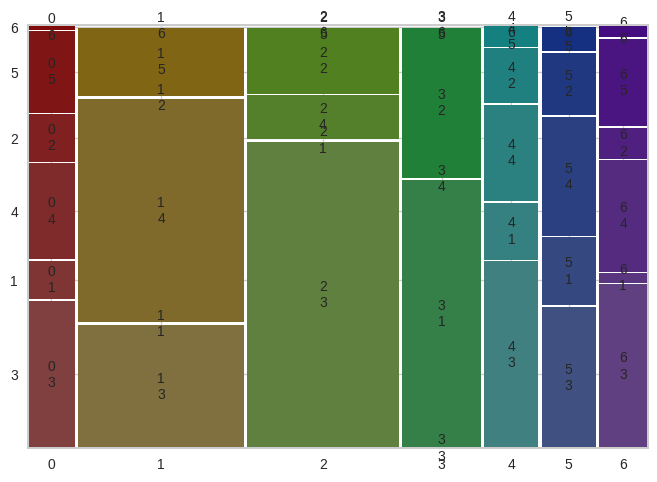

In [ ]:
# [같이 하기] 'Age' 열에 대해 crosstab을 활용해서 clust별 범주별 합계를 확인 해보자.
# crosstab의 margins='True'을 활용하면 행 합, 열 합을 추가할 수 있다.
# pro_df 변수에 할당해서 확인해보자.

feature = 'AGE'

pro_df1 = pd.crosstab([result[feature]], result['cluster'], margins=True)

# 비율로도 한번 확인 해보자.

pro_df2 = pd.crosstab([result[feature]], result['cluster'], margins=True, normalize='columns')
pro_df2 = pro_df2.round(3)

# 합치기, concat
pro_df = pd.concat([pro_df1, pro_df2], axis=1)

# pro_df 확인
display(pro_df)

# 시각화를 해 봅시다.
mosaic(result.sort_values('cluster'), ['cluster', feature] )
plt.show()

<b>**'age' 변수에 대한 클러스터별 특징을 파악해보고 아래 주석에 적어보자!**
( 바로 ppt에 작성을 해도 상관없다)

In [ ]:
# [같이 하기]
'''
1번 클러스터 : ㅁㄴㅇㄹ
x축은 클러스터, y축은 age컬럼.
플롯 안에 위에 숫자 : 클러스터, 아래 숫자 : age.
'''
#0번	비교적 고른 군집 (20~50대 이상 전 연령층 분포) //특정 세대 타깃이 어려움 → 범용성 높은 보험, 가족 단위 상품 추천
#1번	대부분 40대 이상, 20~30대 거의 없음	//중장년층 대상 → 건강검진 연계 상품, 실손보험, 은퇴설계형 보험 적합
#2번	40대 집중, 20대 없음 //경제활동 왕성한 중년층 → 자산증식형 보험, 종신/연금보험 제안
#3번	20~30대로 이루어진 젊은 군집//사회초년생/미혼층 중심 → 저가형 실손보험, 자동차보험, 라이프플랜 설계 보험 적합
#4번	전 연령층 고르게 분포 (1~4)	// 특징 없음, 특정 타겟팅 어려움
#5번	클러스터 4와 유사 (1~5 고르게 분포)	//특징 없음, 클러스터 4와 동일함
#6번	40대 이상 비율 높고 고령층 가장 많음//노년층 타겟 → 치매보험, 간병보험, 사후 대비 상품 중심 전략 필요


'\nx축은 클러스터, y축은 age컬럼.\n플롯 안에 위에 숫자 : 클러스터, 아래 숫자 : age.\n'

### **2) 등록(계/피)**

cluster,0,1,2,3,4,5,6,All,0,1,2,3,4,5,6,All
등록(계/피),,,,,,,,,,,,,,,,
계약자,747,2572,2388,1225,852,875,766,9425,0.79,0.78,0.79,0.77,0.79,0.81,0.79,0.79
피보험자,204,735,631,364,227,205,209,2575,0.21,0.22,0.21,0.23,0.21,0.19,0.21,0.21
All,951,3307,3019,1589,1079,1080,975,12000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


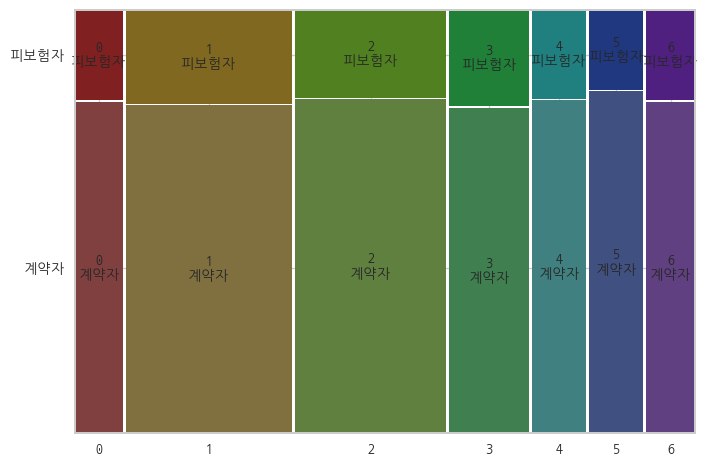

In [ ]:
# [문제 13] '등록(계/피)' 열에 대해 crosstab을 활용해서 clust별 범주별 합계를 확인 해보자.
feature = '등록(계/피)'

pro_df1 = pd.crosstab([result[feature]], result['cluster'], margins=True)

# 비율로도 한번 확인 해보자.

pro_df2 = pd.crosstab([result[feature]], result['cluster'], margins=True, normalize='columns')
pro_df2 = pro_df2.round(3)

# 합치기, concat
pro_df = pd.concat([pro_df1, pro_df2], axis=1)

# pro_df 확인
display(pro_df)

# 시각화를 해 봅시다.
mosaic(result.sort_values('cluster'), ['cluster', feature] )
plt.show()


<b>**'등록(계/피)' 변수에 대한 클러스터별 특징을 파악해보고 아래 주석에 적어보자!**
( 바로 ppt에 작성을 해도 상관없다)

In [ ]:
#[문제 14]
'''
등록한 사람 기준으로 나눈 것인가?
0. 전체 클러스터를 봤을 때 계약자와 피보험자의 비율은 유사함. (대부분 계약자가 등록한 것 같아 보인다. & 계약자와 피보험자의 비율은 비슷해보임)
1. 1번 클러스터 & 2번 클러스터 : 등록(계/피) 컬럼에 대해 1번과 2번 군집으로 나뉜 데이터 비중이 가장 많다. ⭐
'''
# #[문제 14]
# 클러스터 0:
# 계약자가 대부분을 차지하는 군집으로, 주로 계약자가 많은 군집입니다.

# 클러스터 1:
# 계약자 비율이 높은 군집으로, 계약자가 다수인 군집입니다.

# 클러스터 2:
# 계약자 비율이 높은 군집으로, 피보험자와 계약자 비율이 비교적 균형을 이루고 있습니다.

# 클러스터 3:
# 계약자 비율이 높은 군집으로, 계약자가 전체의 77%를 차지하는 특징을 보입니다.

# 클러스터 4:
# 계약자 비율이 높은 군집으로, 계약자가 79%를 차지하며 피보험자와 비율이 거의 비슷합니다.

# 클러스터 5:
# 계약자 비율이 81%로 가장 높은 군집으로, 계약자가 압도적으로 많은 군집입니다.

# 클러스터 6:
# 계약자 비율이 높은 군집으로, 계약자가 79%를 차지하는 군집입니다.

###///모든 군집의 계약자 비율이 약 80% 등록(계/피)변수로는 특징을 찾을 수 없음

'\n등록한 사람 기준으로 나눈 것인가?\n0. 전체 클러스터를 봤을 때 계약자와 피보험자의 비율은 유사함. (대부분 계약자가 등록한 것 같아 보인다. & 계약자와 피보험자의 비율은 비슷해보임)\n1. 1번 클러스터 & 2번 클러스터 : 등록(계/피) 컬럼에 대해 1번과 2번 군집으로 나뉜 데이터 비중이 가장 많다. ⭐\n'

### **3) 성별**

cluster,0,1,2,3,4,5,6,All,0,1,2,3,4,5,6,All
성별,,,,,,,,,,,,,,,,
0,486,1712,1509,816,596,553,477,6149,0.51,0.52,0.50,0.51,0.55,0.51,0.49,0.51
1,465,1595,1510,773,483,527,498,5851,0.49,0.48,0.50,0.49,0.45,0.49,0.51,0.49
All,951,3307,3019,1589,1079,1080,975,12000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


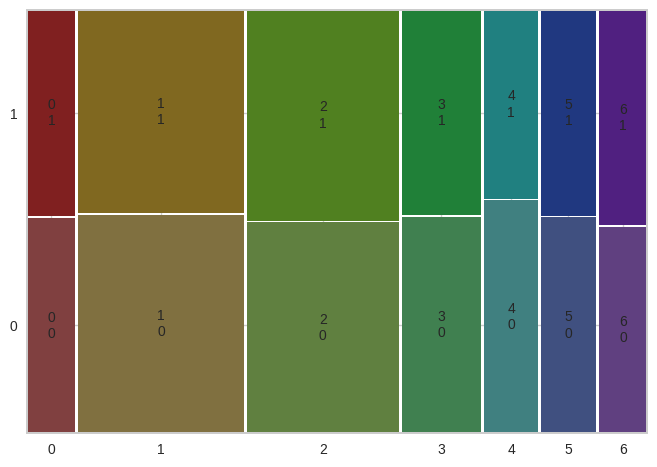

In [ ]:
# [문제 15] '성별' 열에 대해 crosstab을 활용해서 clust별 범주별 합계를 확인 해보자.
feature = '성별'

pro_df1 = pd.crosstab(result[feature], result['cluster'], margins = True)
pro_df2 = pd.crosstab([result[feature]], result['cluster'], margins=True, normalize='columns')
pro_df2.round(3)

pro_df = pd.concat([pro_df1, pro_df2], axis = 1)
display(pro_df)

mosaic(result.sort_values('cluster'), ['cluster', feature] )
plt.show()

<b>**'성별' 변수에 대한 클러스터별 특징을 파악해보고 아래 주석에 적어보자!**
( 바로 ppt에 작성을 해도 상관없다)

In [ ]:
# [문제16]
'''
교안에서 성별은 여 = 0, 남 = 1 이라고 되어있었음.
1. 1, 2 클러스터 : 성별 데이터의 비중은 1, 2번 군집이 전체에서 약 50%를 차지함.
2. 보험은 등록 비율은 전체적으로 반반이지만, 아주 약간 여성들의 보험계약이 많은 것으로 보임.
2-1. 특히 4번 클러스터에서는 다른 클러스터와 비교했을 때, 남성과 여성의 차이가 유의미해보임.⭐
'''
#[문제16]
# 클러스터 0:
# 특징: 성별 분포가 거의 균등합니다. 남성 49%, 여성 51%로 성별에 큰 차이가 없으며, 상대적으로 균형 잡힌 분포를 보입니다.

# 클러스터 1:
# 특징: 성별 분포는 여전히 균등하지만 여성 비율이 조금 더 높은 52%입니다. 남성은 48%로, 비슷한 분포를 보이고 있습니다.

# 클러스터 2:
# 특징: 이 군집에서는 성별 비율이 완전히 동일합니다. 남성과 여성이 각각 50%씩 존재하여 성별의 차이가 없습니다.

# 클러스터 3:
# 특징: 성별 분포가 거의 균등하지만 여성이 51%로 조금 더 많은 비율을 차지합니다. 남성은 49%로 비슷한 비율입니다.

# 클러스터 4:
# 특징: 남성이 여성보다 약간 더 많은 비율을 차지하고 있습니다. 여성 55%, 남성 45%로 비교적 여성이 다소 우세한 분포입니다.

# 클러스터 5:
# 특징: 성별 비율이 거의 균등합니다. 남성 49%, 여성 51%로 차이가 거의 없습니다.

# 클러스터 6:
# 특징: 성별 분포가 비슷하며, 남성이 51%로 여성보다 약간 더 많습니다.

###////마찬가지로 클러스터 별 성별분포가 비슷함. 모든 클러스터에서 남자의 수가 약간 적게 나옴



'\n교안에서 성별은 여 = 0, 남 = 1 이라고 되어있었음.\n1. 1, 2 클러스터 : 성별 데이터의 비중은 1, 2번 군집이 전체에서 약 50%를 차지함.\n2. 보험은 등록 비율은 전체적으로 반반이지만, 아주 약간 여성들의 보험계약이 많은 것으로 보임.\n2-1. 특히 4번 클러스터에서는 다른 클러스터와 비교했을 때, 남성과 여성의 차이가 유의미해보임.\n'

### **4) willingness to pay/stay(수치)**

Willingness to pay/Stay                  
                            max  min  mean median
cluster                                          
0                         65.21 3.52 11.63   9.42
1                         52.35 2.51  8.08   6.16
2                         49.69 2.05  7.68   5.67
3                         54.86 2.47  8.10   6.19
4                         51.74 2.09  7.53   5.79
5                         49.79 2.44  8.22   6.01
6                         92.50 3.41 15.85  11.24

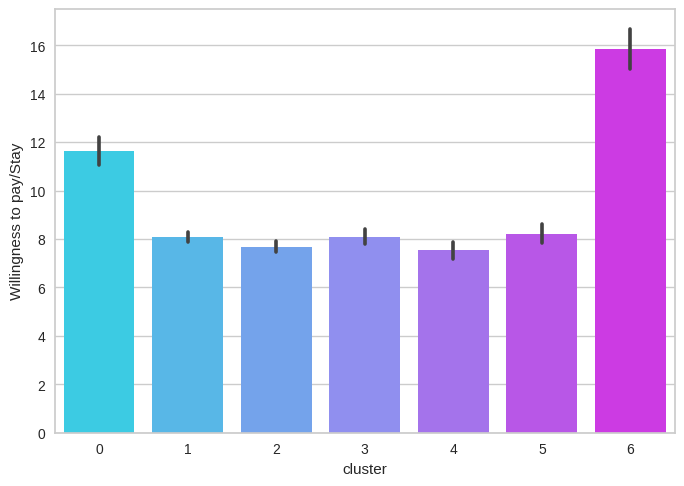

In [ ]:
# [같이 하기] WTP의 경우 '보험 유지 기대 확률'로 각 clust 별 min,max,mean,median 통계 값으로 확인해보자.
# groupby 와 agg() 메소드를 활용하여 도출해 보자.

feature = 'Willingness to pay/Stay'
display(result[['cluster',feature]].groupby(['cluster']).agg(['max','min','mean','median']))

# 시각화를 해 봅시다.
sns.barplot(x='cluster', y=feature, data=result, palette='cool')
# sns.barplot(x='cluster', y=feature, data=result, estimator=np.median, palette='cool') # 이렇게 하면 중간값을 기준으로 해줌. estimator를 바꿔주면 됨.
plt.show()


<b>**'WTP' 변수에 대한 클러스터별 특징을 파악해보고 아래 주석에 적어보자!**
( 바로 ppt에 작성을 해도 상관없다)

In [ ]:
# [같이 하기]
'''
1번 클러스터에서 wtp 평균값이 가장 높다.
6번 클러스터에서 wtp 평균값이 가장 높다.
우선 가장 중요한 feature를 선정하고 우선순위에 맞게 클러스터를 설정한 후 그에 맞는 전략을 수립하면 될 것 같다.
'''
# # [같이 하기]
# 클러스터 0:
# 특징: WTP 값의 분포가 넓고, 평균적으로 11.63으로 다른 클러스터보다 다소 높은 수준입니다. 최댓값이 65.21로 크게 분포하는 값들이 있어, 일부 사용자는 높은 WTP를 보입니다.
#->프리미엄 건강보험, 선택형 플랜, 고급형 옵션 유도

# 클러스터 1:
# 특징: 평균 WTP는 8.08로 비교적 낮은 수준이며, 최댓값 52.35로 높은 WTP를 가진 일부 사용자가 있지만, 대다수의 값은 상대적으로 낮습니다. 중앙값이 6.16으로, 중간값도 낮은 편입니다.

# 클러스터 2:
# 특징: 평균 7.68로 비교적 낮은 WTP를 보입니다. 최댓값은 49.69로 상당히 높은 값도 있지만, 대부분의 값은 낮은 수준입니다.

# 클러스터 3:
# 특징: 평균 8.10으로 WTP가 다소 낮은 수준입니다. 최댓값은 54.86으로 높지만, 많은 값들이 낮고, 중앙값 6.19 역시 낮은 수준입니다.

# 클러스터 4:
# 특징: 평균 7.53으로 다른 클러스터에 비해 낮은 WTP를 보입니다. 최댓값은 51.74로 상대적으로 높은 값도 있지만, 대부분의 값은 낮고 중앙값 5.79도 낮습니다.

# 클러스터 5:
# 특징: 평균 8.22로 다른 클러스터와 비슷한 수준이며, 최댓값은 49.79로 높은 WTP 값을 가진 사용자가 있지만, 대부분은 낮은 값을 보입니다.

# 클러스터 6:
# 특징: 평균 15.85로 다른 클러스터에 비해 가장 높은 WTP를 보입니다. 최댓값은 92.50으로 매우 높은 WTP를 가진 사용자가 있으며, 중앙값도 11.24로 상대적으로 높은 수준입니다.
# ->고가형 암보험, 노후 간병/치매 보험, 프리미엄 건강상품 타겟팅


###//// 대체로 중장년층이 많은 군집에서 높은 WTP 높은 기대값이 나옴. 중장년층은 이미 충성심이 있으며 건강위험에 대해 생각함.
###//// 젊은 세대의WTP를 올릴 보험(?)이 요구됨
###WTP가 높고 중장년층 많은 군집(0, 6)
#→ 이미 보험에 대한 인식이 높고, 실제 건강/노후 리스크에 민감함
#→ “보장 강화”, *“프리미엄 상품”*에 대한 수요 높음

# WTP가 낮고 젊은 층 중심 군집(3, 4, 5)
#→ 보험에 대한 필요성 인식 부족 or 가격 민감성 큼
#→ “가성비 강조”, “생활 밀착형”, “직관적 혜택” 제시 필요
#→ 예: 모바일 앱 할인, 실적 기반 리워드 제공형 보험

'\n1번 클러스터에서 wtp 평균값이 가장 높다.\n6번 클러스터에서 wtp 평균값이 가장 높다.\n우선 가장 중요한 feature를 선정하고 우선순위에 맞게 클러스터를 설정한 후 그에 맞는 전략을 수립하면 될 것 같다.\n'

### **5) 상품 타입**

cluster,0,1,2,3,4,5,6,All,0,1,2,3,4,5,6,All
상품타입,,,,,,,,,,,,,,,,
고급,951,0,0,0,1,0,123,1075,1.00,0.00,0.00,0.00,0.00,0.00,0.13,0.09
기본,0,2212,2004,1123,699,709,531,7278,0.00,0.67,0.66,0.71,0.65,0.66,0.54,0.61
중급,0,1095,1015,466,379,371,321,3647,0.00,0.33,0.34,0.29,0.35,0.34,0.33,0.30
All,951,3307,3019,1589,1079,1080,975,12000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


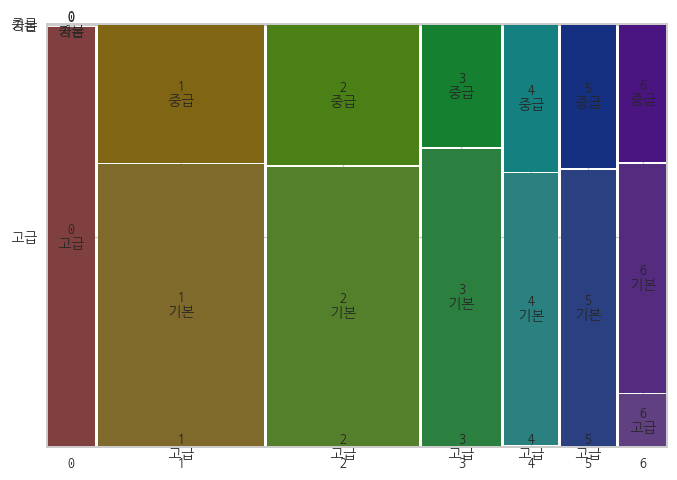

In [ ]:
# [문제 17] '상품타입' 열에 대해 crosstab을 활용해서 clust별 범주별 합계를 확인 해보자.
feature = '상품타입'

pro_df1 = pd.crosstab(result[feature], result['cluster'], margins=True)
pro_df2 = pd.crosstab(result[feature], result['cluster'], normalize= 'columns',margins=True)
pro_df = pd.concat([pro_df1,pro_df2], axis=1)
display(pro_df)

mosaic(result.sort_values('cluster'), ['cluster', feature] )
plt.show()

<b>**'상품타입' 변수에 대한 클러스터별 특징을 파악해보고 아래 주석에 적어보자!**
( 바로 ppt에 작성을 해도 상관없다)

In [ ]:
#[문제18]
'''
우리는 세그먼트를 찾는 중임.
표로 정리한 걸 봤을 때 고급을 가입한 사람이 정말 없는 걸 알 수 있음
0번~5번 클러스터 : 고급이 클러스터에 들어가있지 않기 때문에 무의미한 클러스터.
6번 클러스터가 다른 컬럼과 비교했을 때 유의미한 결과를 볼 수 있을듯 ⭐
'''
# #[문제18]
# 클러스터 0:
# 고급 상품에만 속해 있으며, 100% 고급 상품 사용자.

# 클러스터 1:
# 기본 상품을 주로 보유한 군집으로, 67%가 기본 상품을 보유하고 있음.
# 중급 상품도 일부 보유하며, 33%가 중급 상품을 보유.


# 클러스터 6:
# 고급 상품을 13%가 보유하고 있으며, 기본 상품과 중급 상품이 각각 55%, 33%로 분포.


###대체로 0번을 제외한 모든 군집에서 기본보험을 가장 선호함 -> 고급은 0번 군집을 보고 체크
###중급과 고급 보험에 대한 해택이나 광고를 통해 유입이 필요하다고 보여짐
##기본 보험 중심:
#대부분의 클러스터가 기본 상품을 65~71% 수준으로 보유
##이는 가격 민감도가 높고, 가입 허들이 낮은 상품에 대한 선호를 의미함
#기본 상품은 진입 포인트로 유지하되, 업그레이드 유도가 필요

#중급 상품 보유는 일부 클러스터에 존재
#클러스터 1, 2, 4, 5는 중급 상품 33~35% 보유
#→ 이들은 업셀링 대상으로 적합. “생활+건강 종합 보장형” 상품 제안 가능
#고급 상품은 클러스터 0, 6만 존재
#→ 클러스터 0은 완전히 고급 상품만 보유, 충성도 높은 고가 고객
#→ 클러스터 6은 고급 상품 진입 가능성이 있는 혼합형 고객



'\n우리는 세그먼트를 찾는 중임.\n표로 정리한 걸 봤을 때 고급을 가입한 사람이 정말 없는 걸 알 수 있음\n0번~5번 클러스터 : 고급이 클러스터에 들어가있지 않기 때문에 무의미한 클러스터.\n6번 클러스터가 다른 컬럼과 비교했을 때 유의미한 결과를 볼 수 있을듯 ⭐\n'

### **6) 교육수준**

cluster,0,1,2,3,4,5,6,All,0,1,2,3,4,5,6,All
교육수준,,,,,,,,,,,,,,,,
고졸이하,301,962,1031,516,333,0,334,3477,0.32,0.29,0.34,0.32,0.31,0.00,0.34,0.29
대학졸업,553,2345,1988,1073,602,0,544,7105,0.58,0.71,0.66,0.68,0.56,0.00,0.56,0.59
박사,20,0,0,0,40,353,26,439,0.02,0.00,0.00,0.00,0.04,0.33,0.03,0.04
석사,77,0,0,0,104,727,71,979,0.08,0.00,0.00,0.00,0.10,0.67,0.07,0.08
All,951,3307,3019,1589,1079,1080,975,12000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


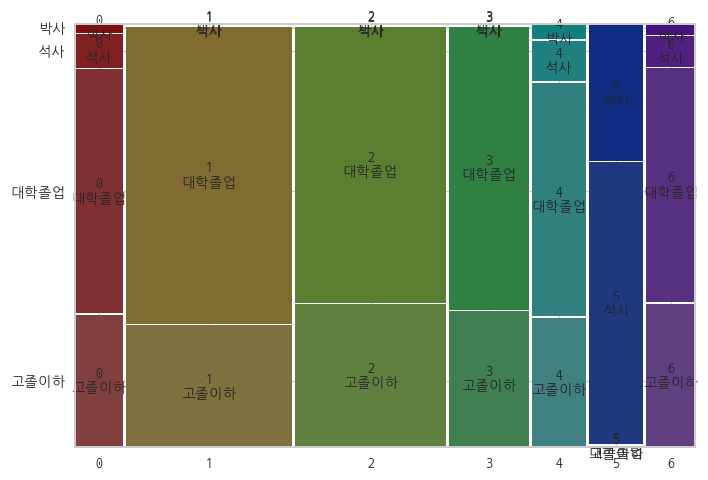

In [ ]:
# [문제 19] '교육수준' 열에 대해 crosstab을 활용해서 clust별 범주별 합계를 확인 해보자.
feature = '교육수준'

pro_df1 = pd.crosstab(result[feature], result['cluster'], margins=True)
pro_df2 = pd.crosstab(result[feature], result['cluster'], normalize= 'columns',margins=True)
pro_df = pd.concat([pro_df1,pro_df2], axis=1)
display(pro_df)

mosaic(result.sort_values('cluster'), ['cluster', feature] )
plt.show()


<b>**'교육수준' 변수에 대한 클러스터별 특징을 파악해보고 아래 주석에 적어보자!**
( 바로 ppt에 작성을 해도 상관없다)

In [ ]:
#[문제20]
'''
교육수준에 관련한 클러스터는 0인 값이 많다. 따라서 0이 가장 적은 클러스터를 보는 것이 도움이 될 듯 싶다.
0. 1번과 2번 클러스터에 데이터의 비중이 가장 높음. (데이터가 가장 많다)
1. 0번, 4번, 6번 클러스터에 있는 데이터가 적더라도 데이터가 골고루 분포되어있기에 0번과 4번 클러스터를 보는 것이 나을것 같다.⭐
1-1. 데이터 전처리 및 분석에서 확인했듯 대학 졸업자들의 보험 등록 비율이 높게 나타났다.
2. 5번 클러스터는 대학 졸업의 비율이 0으로 나타났다.
'''

### 교육수준별 Cluster 구성 특징 요약

| Cluster | 주요 특성 요약 |
|---------|----------------|
| **0** | - 고졸 이하(31.7%)와 대학졸업(58.1%) 혼합 구조<br>- 석사(8.1%), 박사(2.1%) 포함 → **고/중/저 학력 고루 분포** |
| **1** | - **대학졸업 70.9%로 가장 높음**, 고졸 이하 29.1%<br>- 고학력 중심의 실용형 중산층 고객 |
| **2** | - **고졸 이하 비중 가장 높음 (34.2%)**, 석/박사 없음<br>- 대학졸업 중심이나 학력 편차 적음 → **중간층 실속 고객** |
| **3** | - 고졸 이하 32.5%, 대학졸업 67.5% → **학력 평균형 구성**<br>- 석사·박사 없음 → **MZ세대 및 사회초년생 비중 가능성** |
| **4** | - 석사 9.6%, 박사 3.7% 포함 → **고학력 비중 높은 군집** |
| **5** | - 석사 67.3%, 박사 32.7% → **거의 전원이 고학력(석박사)** |
| **6** | - 고졸 이하(34.3%), 대학졸업(55.8%), 석박사도 일부 포함 → **전체 분포와 유사한 평균형 구성** |

---

### 교육수준 기반 마케팅 전략 제안

| Cluster | 전략 키워드 | 전략 설명 |
|---------|-------------|------------|
| **0** | 맞춤형 콘텐츠 혼합 | 다양한 학력 혼합층 → 고급/간편형 정보 제공 병행 |
| **1** | 고학력 신뢰 중심 | 대학졸 이상 비중 높음 → **데이터 기반·신뢰 중심 커뮤니케이션** |
| **2** | 이해 쉬운 콘텐츠 제공 | 고졸 이하 비중 높음 → **용어 최소화, 시각 중심 자료 제공** |
| **3** | 실용·가성비 강조 | MZ세대 구성 가능성 높음 → **짧고 직관적인 정보 제공 + 가격 중심** |
| **4** | 고학력 소통 강화 | 석박사 비중 높은 군집 → **분석적 사고 기반 설명, 리포트형 콘텐츠** |
| **5** | 전문가 대상 콘텐츠 | 고학력 전용 특화 → **전문 용어 포함, 금융전문 리포트 제공** |
| **6** | 전체 평균형 | 다양한 학력 섞인 구성 → **중간 수준 콘텐츠로 대중 커버 가능** |


### **7) 고용상태**

cluster,0,1,2,3,4,5,6,All,0,1,2,3,4,5,6,All
고용상태,,,,,,,,,,,,,,,,
FALSE,6,0,255,0,39,27,33,360,0.01,0.00,0.08,0.00,0.04,0.03,0.03,0.03
고용,611,3307,0,1589,632,800,579,7518,0.64,1.00,0.00,1.00,0.59,0.74,0.59,0.63
무직,233,0,2089,0,285,139,282,3028,0.25,0.00,0.69,0.00,0.26,0.13,0.29,0.25
휴직,101,0,675,0,123,114,81,1094,0.11,0.00,0.22,0.00,0.11,0.11,0.08,0.09
All,951,3307,3019,1589,1079,1080,975,12000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


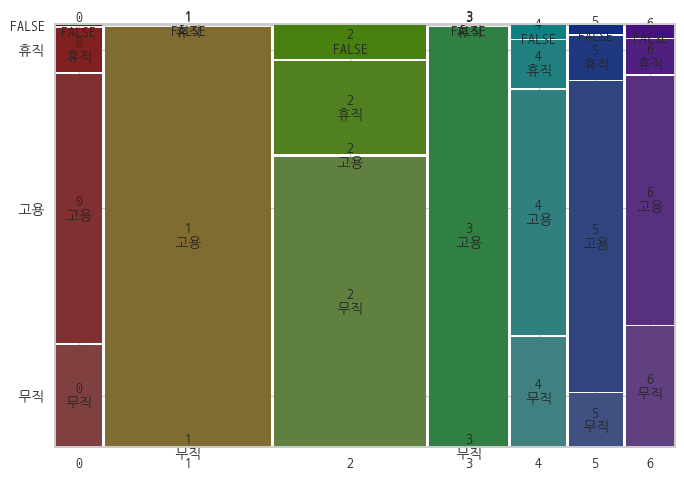

In [ ]:
# [문제 21] '고용상태' 열에 대해 crosstab을 활용해서 clust별 범주별 합계를 확인 해보자.
feature = '고용상태'

pro_df1 = pd.crosstab(result[feature], result['cluster'], margins=True)
pro_df2 = pd.crosstab(result[feature], result['cluster'], normalize= 'columns',margins=True)
pro_df = pd.concat([pro_df1,pro_df2], axis=1)
display(pro_df)

mosaic(result.sort_values('cluster'), ['cluster', feature] )
plt.show()



<b>**'고용상태' 변수에 대한 클러스터별 특징을 파악해보고 아래 주석에 적어보자!**
( 바로 ppt에 작성을 해도 상관없다)

In [ ]:
#[문제 22]
'''
1. 1번과 2번 클러스터에 데이터가 많이 분포 되어있음.
  1-1. 1번 클러스터는 데이터가 고르게 분포되어 있지 않음. 만약 우선순위가 '고용'자들이 우선이라면 1번 클러스터가 중요하다.
2. 0, 4, 5, 6번 클러스터가 데이터가 고르게 분포되어 있음. 그러나 데이터의 수가 적다.
3. 2번 클러스터 : 다른 클러스터에 비해 FALSE의 데이터가 많으므로 유의하도록 하자.
'''

### 고용상태별 Cluster 구성 특징 요약

| Cluster | 주요 특성 요약 |
|---------|----------------|
| **0** | - 고용(64.2%) + 무직(24.5%) + 휴직(10.6%) 구성<br>- **가장 균형 잡힌 고용구조**, 소득계층 혼합 |
| **1** | - **100% 고용 상태** → 설계사 유입 등 의도적 분류 가능성<br>- 안정적인 납입 기반의 고객층 |
| **2** | - 무직 69.2%, 휴직 22.4% → **취약계층 중심**, 납입 여력 낮음 |
| **3** | - **100% 고용 상태**, 무직/휴직 없음<br>- **MZ세대 단기근로층** 가능성 |
| **4** | - 고용(58.6%), 무직(26.4%), 휴직(11.4%) → 실업과 고용 혼재 |
| **5** | - 고용(74.1%) 비중 높음, 휴직/무직도 일부 포함 → 평균 이상 안정군 |
| **6** | - 고용(59.4%), 무직(28.9%), 휴직(8.3%) → **고용불안 고객 다수 포함**

---

### 고용상태 기반 마케팅 전략 제안

| Cluster | 전략 키워드 | 전략 설명 |
|---------|-------------|------------|
| **0** | 유연한 상품 옵션 | 고용유형 다양 → **납입 조건 선택형, 맞춤형 메시지** 제공 |
| **1** | 소득 안정 기반 업셀링 | 고용률 100% → **추가 보장 제안 및 프리미엄 확대 전략** 유효 |
| **2** | 납입 유예 및 간편 상품 | 무직/휴직 고객 다수 → **저가형 보장 상품**, **소액 납입 옵션 제공** 필요 |
| **3** | 디지털 간편 상품 | 고용률 100%이나 MZ 가능성 높음 → **디지털 전용, 라이프스타일 기반 상품 구성** |
| **4** | 실속 중심 리마인드 | 고용/무직 혼재 → **유지 케어 캠페인 및 가격-보장 밸런싱** 필요 |
| **5** | 안정층 대상 혜택 강화 | 고용률 높고 이탈 위험 낮음 → **장기 유지 고객 리워드 전략** 적합 |
| **6** | 실직 대비형 보장 강조 | 무직 비율 높음 → **소득 공백 보장형 특약**, **신속 갱신 안내 체계 필요** |



### **8) 소득(수치)**

소득                                    
               max       min         mean       median
cluster                                               
0        128243500         0  48108641.22  45389300.00
1         96421000  24045000  53765547.90  52493000.00
2         39601100         0   7754089.80         0.00
3        132020900  82386000 101903323.03 100976700.00
4        131727200         0  45125778.41  38944400.00
5        131674400         0  55498152.41  52768500.00
6        130366500         0  40504390.36  35901000.00

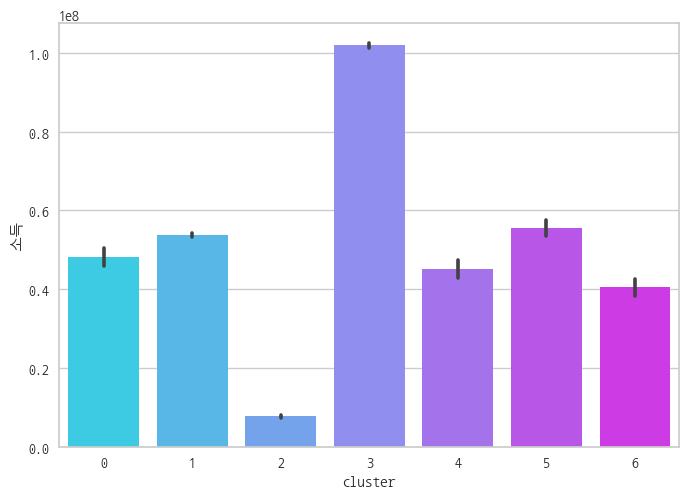

In [ ]:
# [문제 23] '소득'은 수치형으로 각 clust 별 min,max,mean,median 통계 값으로 확인해보자.
# groupby 와 agg() 메소드를 활용하여 도출해 보자.
feature = '소득'

display(result[['cluster',feature]].groupby(['cluster']).agg(['max','min','mean','median']))

# 시각화를 해 봅시다.
sns.barplot(x='cluster', y=feature, data=result, palette='cool')
# sns.barplot(x='cluster', y=feature, data=result, estimator=np.median, palette='cool') # 이렇게 하면 중간값을 기준으로 해줌. estimator를 바꿔주면 됨.
plt.show()



<b>**'소득' 변수에 대한 클러스터별 특징을 파악해보고 아래 주석에 적어보자!**
( 바로 ppt에 작성을 해도 상관없다)

In [ ]:
#[문제24]
'''
2번 클러스터 : 소득의 평균이 가장 낮음
3번 클러스터 : 소득의 평균이 가장 높게 나타남.
'''

### 소득 통계 기반 Cluster별 고객 특성 요약

| Cluster | 평균 소득(₩) | 중앙값(₩) | 소득 특성 요약 |
|---------|---------------|-------------|----------------|
| **0** | 약 48,108,640 | 45,389,300 | 소득 안정적이나 고소득은 아님, **중상위 실속형** |
| **1** | 약 53,765,550 | 52,493,000 | **전체 평균 중 가장 안정적이고 고른 중고소득층** |
| **2** | 약 7,754,090  | 0          | **소득 취약층**, 무소득 비율 매우 높음 |
| **3** | **101,903,300** | **100,976,700** | **전체 최고 소득군**, 초고소득 중심 |
| **4** | 약 45,125,780 | 38,944,400 | 평균형 소득 분포, **중위권 고객층** |
| **5** | 약 55,498,150 | 52,768,500 | 안정적 고소득군, **업셀링 최적** |
| **6** | 약 40,504,390 | 35,901,000 | 약간 낮은 중소득 분포, **유지관리 필요층**

---

### 소득 기반 마케팅 전략 제안

| Cluster | 전략 키워드 | 전략 설명 |
|---------|-------------|------------|
| **0** | 실속형 보장 확대 | 중상위 소득 대비 프리미엄화 여지 있음 → **선택 보장 추천** |
| **1** | 균형형 업셀링 | 고른 소득구조 → **보장 확대 및 상품 다양화 제안 적합** |
| **2** | 저소득 맞춤형 보장 | 무소득 비율 매우 높음 → **납입유예형, 단기 보장 상품 필요** |
| **3** | 초고소득 고객 전용 상품 | VIP 자산 관리형 상품, **장기 보장 + 세제 혜택 특화 전략** |
| **4** | 보장-혜택 균형 마케팅 | 평균형 고객층 → **혜택 중심 프로모션 + 리마인드 전략** |
| **5** | 프리미엄 업셀링 | 고소득군 → **고보장 확대, 장기 리워드 프로그램 제안** |
| **6** | 납입 여력 고려형 유지 전략 | 소득은 낮으나 구성 다양 → **유지 케어 중심 전략** 필요 |



### **9) 결혼여부**

In [ ]:
# [문제 25] '결혼여부' 열에 대해 crosstab을 활용해서 clust별 범주별 합계를 확인 해보자.
feature = '결혼여부'

pro_df1 = pd.crosstab(result[feature], result['cluster'], margins=True)
pro_df2 = pd.crosstab(result[feature], result['cluster'], normalize= 'columns',margins=True)
pro_df = pd.concat([pro_df1,pro_df2], axis=1)
display(pro_df)

mosaic(result.sort_values('cluster'), ['cluster', feature] )
plt.show()



<b>**'결혼여부' 변수에 대한 클러스터별 특징을 파악해보고 아래 주석에 적어보자!**
( 바로 ppt에 작성을 해도 상관없다)

### 결혼여부별 Cluster 구성 특징 요약

| Cluster | 기혼 (%) | 미혼 (%) | 주요 특성 요약 |
|---------|----------|-----------|----------------|
| **0** | 59.9% | 40.1% | 기혼 다수, 안정된 가족 중심 고객군 |
| **1** | **67.5%** | 32.5% | 전체에서 기혼 비율 가장 높음, 가족 보장 선호 |
| **2** | 39.3% | **60.7%** | 미혼 중심 → 1인 고객 또는 독립 초기층 |
| **3** | 67.5% | 32.5% | MZ 세대 가능성 있으나 기혼 비율 높음 |
| **4** | 62.7% | 37.3% | 전통적 가족구조 비중 높음 |
| **5** | 65.0% | 35.0% | 기혼 중심, 패밀리 보장 수요 존재 |
| **6** | 53.0% | 47.0% | 기혼/미혼 균형 구조, 다양성 존재 |

---

### 결혼여부 기반 마케팅 전략 제안

| Cluster | 전략 키워드 | 전략 설명 |
|---------|--------------|------------|
| **0** | 가족 보장 강화 | 기혼 다수 → **배우자/자녀 특약 연계 상품 적합** |
| **1** | 패밀리 패키지 집중 | 전체 기혼 비중 최고 → **가족 단위 보장 설계** 유리 |
| **2** | 1인 보장 중심 | 미혼 중심 → **단독 가입자 전용 상품, 저렴한 유지형** |
| **3** | 맞춤형 보장 다양화 | 기혼 비율 높음 → **혼합형 설계 유효** (가족 + 본인 중심 보장) |
| **4** | 가족 중심 메시지 | 기혼 비중 높음 → **보장 범위 강조 마케팅 적합** |
| **5** | 자녀보장 특화 전략 | 가족 단위 구매 가능성 높음 → **자녀 특약 or 2인 보장 제안** |
| **6** | 혼합형 유지 전략 | 기혼·미혼 균형 → **라이프사이클 기반 전환 전략 필요** |



### **10) 월 납입액(수치)**

In [ ]:
# [문제 27] '월 납입액'은 수치형으로 각 clust 별 min,max,mean,median 통계 값으로 확인해보자.
# groupby 와 agg() 메소드를 활용하여 도출해 보자.
feature = '월 납입액'
display(result[['cluster',feature]].groupby(['cluster']).agg(['max','min','mean','median']))

# 시각화를 해 봅시다.
sns.barplot(x='cluster', y=feature, data=result, palette='cool')
plt.show()


<b>**'월 납입액' 변수에 대한 클러스터별 특징을 파악해보고 아래 주석에 적어보자!**
( 바로 ppt에 작성을 해도 상관없다)

### 월 납입액 기반 Cluster별 고객 특성 요약

| Cluster | 평균 납입액 (만원) | 중앙값 (만원) | 주요 특성 요약 |
|---------|-------------------|----------------|----------------|
| **0** | 135.3 | 120.0 | 프리미엄 상품 다수, 고정 고액 납입층 |
| **1** | 87.7  | 80.0  | 전형적인 중간 납입 고객, 안정형 |
| **2** | 88.7  | 80.0  | 유사한 중간 납입 구조, 실속 지향형 |
| **3** | 87.6  | 80.0  | 납입은 적지만 균형 있는 구조 |
| **4** | 88.3  | 80.0  | 평균적 납입, 보장-비용 균형 중시 |
| **5** | 88.5  | 80.0  | 비교적 유지력 있는 중간층 고객 |
| **6** | **189.1** | **190.0** | **가장 높은 납입군**, 장기고객, 고급 보장 유력 |

---

### 월 납입액 기반 마케팅 전략 제안

| Cluster | 전략 키워드 | 전략 설명 |
|---------|-------------|------------|
| **0** | 고급 보장 유지 | 고액 납입 지속 고객층 → **프리미엄 보장 강화 + VIP 혜택** |
| **1** | 보장 효율 강조 | 중간 납입층 → **보장 범위 최적화, 선택형 특약 제안** |
| **2** | 실속형 제안 유지 | 실용 지향 고객 → **가격 대비 보장 강화 콘텐츠** 필요 |
| **3** | 납입 부담 완화 | 적정 납입 수준 → **소액 추가 특약 or 리워드 전략** 적합 |
| **4** | 유지율 케어 중심 | 일반형 고객군 → **유지 알림 + 혜택 연계 적립 프로그램** |
| **5** | 안정적 리텐션 강화 | 납입 지속력 높음 → **장기 혜택·포인트 전략 유효** |
| **6** | 프리미엄 업셀링 | 최고 납입층 → **장기 보장 + 세금 혜택 설계 전략 최적** |



### **11) VOC**

In [ ]:
# [문제 29] 'VOC' 열에 대해 crosstab을 활용해서 clust별 범주별 합계를 확인 해보자.
feature = 'VOC'

pro_df1 = pd.crosstab(result[feature], result['cluster'], margins=True)
pro_df2 = pd.crosstab(result[feature], result['cluster'], normalize= 'columns',margins=True)
pro_df = pd.concat([pro_df1,pro_df2], axis=1)
display(pro_df)

mosaic(result.sort_values('cluster'), ['cluster', feature] )
plt.show()



<b>**'VOC' 변수에 대한 클러스터별 특징을 파악해보고 아래 주석에 적어보자!**
( 바로 ppt에 작성을 해도 상관없다)

### 불만접수사례 중심 VOC 분석 요약 (Cluster 기준)

| Cluster | 불만접수사례 수 | 전체 고객 수 | 불만 비율 (%) | 요약 |
|---------|------------------|----------------|----------------|-------|
| **0** | 99건 | 951명 | **10.4%** | 불만 상대적으로 낮음, **안정 고객** |
| **1** | 380건 | 3307명 | **11.5%** | 전체 중 **불만 수 가장 많음**, 고객 수 대비 비율도 높음 |
| **2** | 329건 | 3019명 | **10.9%** | 비율/규모 모두 중간, **불만 개선 여지 있음** |
| **3** | 156건 | 1589명 | **9.8%** | 불만 비율은 낮으나 고객 수 적어 비율 유의 |
| **4** | 107건 | 1079명 | **9.9%** | 평균 수준, **불만 대비 유지율 양호** |
| **5** | **131건** | 1080명 | **12.1%** | **불만 비율 최고**, **우선 대응 대상** |
| **6** | 111건 | 975명 | **11.4%** | **평균 이상 불만 비율**, 고정납입층 대응 필요 |

---

### 불만접수사례 기반 클러스터 마케팅 전략

| Cluster | 전략 키워드 | 전략 설명 |
|---------|--------------|------------|
| **0** | 만족 유지 중심 | 불만 적음 → **혜택 유지·충성 고객 관리 프로그램 집중** |
| **1** | 불만 대응 우선군 | 전체 불만 건수 최다 → **VOC 자동 분류·우선 응대 프로세스 필요** |
| **2** | 피드백 기반 보장 개선 | 비율도 높은 편 → **사전 공지 강화, 맞춤형 피드백 프로모션 진행** |
| **3** | MZ 문의 대응형 케어 | 소규모지만 비율 적지 않음 → **신속 응대/FAQ 링크 자동화 필요** |
| **4** | 평균형 VOC 관리 | 중간 수준 → **모니터링 지속 + 이벤트 연계 응대 시도** |
| **5** | **불만 최다 군집 집중관리** | **심층 분석 필요** (불만유형·시간대·상품), CS 전담 운영 권장 |
| **6** | 리텐션 기반 VOC 방어 | 유지율 높지만 불만도 높음 → **혜택 강조 + 유료고객 전용 응대 채널 추천**



### **12) 타 상품 보유 현황**

In [ ]:
# [문제 31] '타 상품 보유 현황' 열에 대해 crosstab을 활용해서 clust별 범주별 합계를 확인 해보자.
feature = '타 상품 보유 현황'

pro_df1 = pd.crosstab([result[feature]], result['cluster'], margins=True)

# 비율로도 한번 확인 해보자.

pro_df2 = pd.crosstab([result[feature]], result['cluster'], margins=True, normalize='columns')
pro_df2 = pro_df2.round(3)

# 합치기, concat
pro_df = pd.concat([pro_df1, pro_df2], axis=1)

# pro_df 확인
display(pro_df)

# 시각화를 해 봅시다.
mosaic(result.sort_values('cluster'), [ 'cluster', feature])
plt.show()

<b>**'타 상품 보유 현황	' 변수에 대한 클러스터별 특징을 파악해보고 아래 주석에 적어보자!**
( 바로 ppt에 작성을 해도 상관없다)

### 타 상품 보유 현황 기반 Cluster 특성 분석

| Cluster | 1건 (%) | 2건 (%) | 3건 (%) | 4건 이상 (%) | 주요 특성 요약 |
|---------|---------|---------|----------|---------------|----------------|
| **0** | 34.6% | 28.1% | 12.6% | 24.7% | 중간 보유 구조, **균형 잡힌 분산 고객층** |
| **1** | 35.2% | 25.7% | 12.7% | 26.4% | 평균 구조, 타사 서비스 경험 많음 |
| **2** | 34.0% | 25.9% | 13.0% | 27.1% | 4건 이상 비율 높음 → **타사 이용 활발** |
| **3** | 35.7% | 22.6% | 14.4% | 27.2% | 전반적으로 **타사 이용 강한 MZ 경향** |
| **4** | 40.7% | 23.3% | 12.2% | 23.8% | 1건 비중 가장 높음 → **K사만 보유 가능성** ↑ |
| **5** | 37.3% | 24.3% | 13.6% | 24.8% | 실수요 기반 분산 고객층 |
| **6** | 36.4% | 25.1% | 10.8% | **27.7%** | **타사 고다건 고객 최다**, 이탈 위험 또는 비교충성층 |

---

### 마케팅 전략 제안: 타사 상품 보유 수 기반

| Cluster | 전략 키워드 | 전략 설명 |
|---------|-------------|------------|
| **0** | 핵심 충성 고객 육성 | 보유 분산 고객 → **보장 단일화 제안 or 혜택 몰아주기 전략** |
| **1** | 브랜드 가치 강화 | 타사 경험 多 → **차별성 콘텐츠 + 리뉴얼 상품 어필 필요** |
| **2** | 교차전환 유도 | 4건 이상 비중 높음 → **전환 프로모션 or 보장 비교 시뮬레이션** |
| **3** | MZ 대상 멀티플랜 구성 | 비교/이탈 가능성 ↑ → **라이프스타일 맞춤 플랜 묶음 제공** |
| **4** | K사 단일 보유층 유지 강화 | 타사 경험 적음 → **충성 유지 + 장기 리워드 전략** |
| **5** | 교차상품 업셀링 | 2건 보유 많음 → **특약 또는 제휴 상품 번들링 전략 적합** |
| **6** | 고다건 보유 고객 회수 | 타사 집중층 → **재편 상품 제안 + 독점보장 유도 필요**

---

📌 참고:  
- ‘1건’은 타사와 병행 고객 혹은 단일상품 보유 가능성이 높고,  
- ‘4건 이상’은 **복수사/복수상품 가입 고객** → 충성도 낮고 이탈/비교 가능성 높음  
→ 따라서 **다건 보유층일수록 K사로의 상품 통합 유도,**


### **13) 갱신 인센티브**

In [ ]:
# [문제 33] '갱신인센티브' 열에 대해 crosstab을 활용해서 clust별 범주별 합계를 확인 해보자.
feature = '갱신인센티브'

pro_df1 = pd.crosstab([result[feature]], result['cluster'], margins=True)

# 비율로도 한번 확인 해보자.

pro_df2 = pd.crosstab([result[feature]], result['cluster'], margins=True, normalize='columns')
pro_df2 = pro_df2.round(3)

# 합치기, concat
pro_df = pd.concat([pro_df1, pro_df2], axis=1)

# pro_df 확인
display(pro_df)

# 시각화를 해 봅시다.
mosaic(result.sort_values('cluster'), [ 'cluster', feature])
plt.show()


<b>**'갱신인센티브	' 변수에 대한 클러스터별 특징을 파악해보고 아래 주석에 적어보자!**
( 바로 ppt에 작성을 해도 상관없다)

In [ ]:
#[문제 34]
# 모든 clust에서 없음과 포인트의 비율이 각각 20%를 넘지 않는 것을 알 수 있다
# clust 0, 2, 6에서 할인의 비율이 설계사 독려의 비율보다 높다
# clust 1, 4, 5에서 할인의 비율과 설계사 독려의 비율이 비슷하다
# clust 3에서 유일하게 설계사 독려가 44%로 가장 높다

#[문제 34]
# 전반적으로 인센티브 종류가 좀 다양함 할인이 대부분이라고 생각했던 예상과 좀 달랐습니다.
# clust 0,2: 할인을 받은 비중이 가장 높음(50% 대) 이 클러스터 고객님들은 할인에 약간 비중을 좀 더 드리는 게 맞을 듯합니다.
# clust 3: 설계사의 독려로 갱신이 많았던 군집

### **14) 총 지불 금액(수치)**

In [ ]:
# [문제 35] '총지불금액'은 수치형으로 각 clust 별 min,max,mean,median 통계 값으로 확인해보자.
# groupby 와 agg() 메소드를 활용하여 도출해 보자.


feature = '총지불금액'
display(result[['cluster',feature]].groupby(['cluster']).agg(['max','min','mean','median']))

# 시각화를 해 봅시다.
sns.barplot(x='cluster', y=feature, data=result, palette='cool')
plt.show()
# 시각화를 해 봅시다.


<b>**'총지불금액' 변수에 대한 클러스터별 특징을 파악해보고 아래 주석에 적어보자!**
( 바로 ppt에 작성을 해도 상관없다)

In [ ]:
#[문제 36]
# clust 0에서 max = 2663000, clust 6에서 max = 3573000로 다른 것에 비해 높게 나타났다
# clust 6에서 mean = 957000로 가장 크게 나타났다

#[문제 36]
# clust 6: 총 지불 금액이 가장 높은 군집
# clust 0: 총 지불 금액이 두번째로 높은 군집
# clust 3: 총 지불 금액의 평균이 가장 낮은 군집
# 클러스터 6에

### **15) 자동차**

In [ ]:
# [문제 37] '자동차' 열에 대해 crosstab을 활용해서 clust별 범주별 합계를 확인 해보자.

feature = '자동차'

pro_df1 = pd.crosstab([result[feature]], result['cluster'], margins=True)

# 비율로도 한번 확인 해보자.

pro_df2 = pd.crosstab([result[feature]], result['cluster'], margins=True, normalize='columns')
pro_df2 = pro_df2.round(3)

# 합치기, concat
pro_df = pd.concat([pro_df1, pro_df2], axis=1)

# pro_df 확인
display(pro_df)

# 시각화를 해 봅시다.
mosaic(result.sort_values('cluster'), [ 'cluster', feature])
plt.show()


<b>**'자동차' 변수에 대한 클러스터별 특징을 파악해보고 아래 주석에 적어보자!**
( 바로 ppt에 작성을 해도 상관없다)

In [ ]:
#[문제38]
# clust 6에서 고급차의 비율이 47%, 스포츠카의 비율이 53%로 나타났다
# clust 6을 제외한 모든 clust에서 고급차의 비율은 0이다
# clust 1, 2의 스포츠카의 비율은 0이며 clust 0, 3, 4, 5의 비율도 0에 가깝다
# clust 6을 제외한 모든 clust에서 일반세단의 비율이 50% 이상, 컴팩트카의 비율이 20% 이상 나타난다

#[문제38]
# 타 clust들:
# Clust 6: 고급차와 스포츠카 비율이 대부분인 고객 군집으로 이미 재산을 많이 쌓아놓은 분들이 대부분일 수도 있다고 봅니다.
# Clust 6을 타깃으로 고가의 자동차에 맞춘 자동차 보험 상품들이 개발되는 것도 좋지 않을까 싶습니다.

 ### **16) 거주지 사이즈**

In [ ]:
# [문제 39] '거주지사이즈' 열에 대해 crosstab을 활용해서 clust별 범주별 합계를 확인 해보자.

feature = '거주지사이즈'

pro_df1 = pd.crosstab([result[feature]], result['cluster'], margins=True)

# 비율로도 한번 확인 해보자.

pro_df2 = pd.crosstab([result[feature]], result['cluster'], margins=True, normalize='columns')
pro_df2 = pro_df2.round(3)

# 합치기, concat
pro_df = pd.concat([pro_df1, pro_df2], axis=1)

# pro_df 확인
display(pro_df)

# 시각화를 해 봅시다.
mosaic(result.sort_values('cluster'), [ 'cluster', feature])
plt.show()


<b>**'거주지사이즈' 변수에 대한 클러스터별 특징을 파악해보고 아래 주석에 적어보자!**
( 바로 ppt에 작성을 해도 상관없다)

In [ ]:
#[문제40]
# clust 4에서 대의 비율이 100%이다
# clust 1, 2, 3, 5에서의 대의 비율은 0%이다
# clust 4를 제외한 모든 clust에서 중의 비율이 70% 이상 나타난다
# clust 4를 제외한 모든 clust에서 소의 비율이 대략 20% 정도 나타난다

#[문제40]
# clust 4: 거주지 사이즈 대가 가장 많은 집단
# 다만 전반적으로는 사이즈 중이 많아 보여서 거주지 자체는

### **17) 갱신**

In [ ]:
# [문제 41] '갱신' 열에 대해 crosstab을 활용해서 clust별 범주별 합계를 확인 해보자.

feature = '갱신'

pro_df1 = pd.crosstab([result[feature]], result['cluster'], margins=True)

# 비율로도 한번 확인 해보자.

pro_df2 = pd.crosstab([result[feature]], result['cluster'], margins=True, normalize='columns')
pro_df2 = pro_df2.round(3)

# 합치기, concat
pro_df = pd.concat([pro_df1, pro_df2], axis=1)

# pro_df 확인
display(pro_df)

# 시각화를 해 봅시다.
mosaic(result.sort_values('cluster'), [ 'cluster', feature])
plt.show()


<b>**'갱신' 변수에 대한 클러스터별 특징을 파악해보고 아래 주석에 적어보자!**
( 바로 ppt에 작성을 해도 상관없다)

In [ ]:
#[문제42]
# 모든 clust에서 0의 비율이 대략 85% 정도 나타난다
# clust 4에서 0의 비율이 80%로 가장 작으며 clust 1에서 0의 비율이 88%로 가장 크다

#[문제42]
# 전반적으로 갱신이 없는 편(80-90%)
# clust 4의 경우 갱신의 비율이 타 cluster 대비 가장 높은 것으로 드러남
# clust 1의 경우 갱신의 비율이 가장 낮은 그룹(비갱신 비율 거의 90%)

### **18) 지역**

In [ ]:
# [문제 43] '지역' 열에 대해 crosstab을 활용해서 clust별 범주별 합계를 확인 해보자.

feature = '지역'

pro_df1 = pd.crosstab([result[feature]], result['cluster'], margins=True)

# 비율로도 한번 확인 해보자.

pro_df2 = pd.crosstab([result[feature]], result['cluster'], margins=True, normalize='columns')
pro_df2 = pro_df2.round(3)

# 합치기, concat
pro_df = pd.concat([pro_df1, pro_df2], axis=1)

# pro_df 확인
display(pro_df)

# 시각화를 해 봅시다.
mosaic(result.sort_values('cluster'), [ 'cluster', feature])
plt.show()


<b>**'지역' 변수에 대한 클러스터별 특징을 파악해보고 아래 주석에 적어보자!**
( 바로 ppt에 작성을 해도 상관없다)

In [ ]:
#[문제44]
# clust 3을 제외한 모든 clust에서 도시근교의 비율이 가장 높다
# clust 3에서 도시근교와 시골의 비율이 각각 34%, 도심의 비율이 32%이다
# clust 2에서 도시근교의 비율이 91% 가장 크다

#[문제44]
# clust 2 의 경우 도시 근교에 살고 있는 사람의 비중이 높다.
# clust 3의 경우 시골에 살고 있는 사람의 비중이 높다.

### **19) 온라인방문빈도**

In [ ]:
# [문제 45] '온라인방문빈도' 열에 대해 crosstab을 활용해서 clust별 범주별 합계를 확인 해보자.

feature = '온라인방문빈도'

pro_df1 = pd.crosstab([result[feature]], result['cluster'], margins=True)

# 비율로도 한번 확인 해보자.

pro_df2 = pd.crosstab([result[feature]], result['cluster'], margins=True, normalize='columns')
pro_df2 = pro_df2.round(3)

# 합치기, concat
pro_df = pd.concat([pro_df1, pro_df2], axis=1)

# pro_df 확인
display(pro_df)

# 시각화를 해 봅시다.
mosaic(result.sort_values('cluster'), [ 'cluster', feature])
plt.show()


<b>**'온라인방문빈도' 변수에 대한 클러스터별 특징을 파악해보고 아래 주석에 적어보자!**
( 바로 ppt에 작성을 해도 상관없다)

In [ ]:
#[문제46]
# 모든 clust에서 비방문의 비율 대략 75%로 가장 높으며 종종의 비율이 대략 4%로 가장 작다

#[문제46]
# 비방문의 비율들이 크다고 느낍니다.
# 그 중 clust 1,3 의 경우 비교적 비방문의 비율이 낮아 보입니다.
# 고객님들은 전반적으로 방문에 크게 의존하고 계시진 않는 걸로 보입니다.

### **20) 판매채널**

In [ ]:
# [문제 47] '판매채널' 열에 대해 crosstab을 활용해서 clust별 범주별 합계를 확인 해보자.

feature = '판매채널'

pro_df1 = pd.crosstab([result[feature]], result['cluster'], margins=True)

# 비율로도 한번 확인 해보자.

pro_df2 = pd.crosstab([result[feature]], result['cluster'], margins=True, normalize='columns')
pro_df2 = pro_df2.round(3)

# 합치기, concat
pro_df = pd.concat([pro_df1, pro_df2], axis=1)

# pro_df 확인
display(pro_df)

# 시각화를 해 봅시다.
mosaic(result.sort_values('cluster'), [ 'cluster', feature])
plt.show()


<b>**'판매채널' 변수에 대한 클러스터별 특징을 파악해보고 아래 주석에 적어보자!**
( 바로 ppt에 작성을 해도 상관없다)

In [ ]:
#[문제48]
# 모든 clust에서 대리점의 비율이 대략 37%로 가장 크며, 자사영업의 비율이 대략 28%로 그 다음이다
# 모든 clust에서 콜센터의 비율이 대략 20%이며, 인터넷의 비율이 대략 14%로 가장 작다

#[문제48]
# clust 2,6의 경우 타 군집 보다 대리점에서 구매를 많이 했습니다.
#아무래도 인터넷의 경우 직원과 직접적으로 소통할 수단이 적어서 다른 수단을 더 쓰시는 걸로 보입니다.

---------------------------------------------------------------------------------------------
## **(2) 결과 정리**

<font color="1E90FF"><b>★ 20가지 피쳐값에 대해 군집별로 분석해 보았고 인사이트도 도출해 보았다. 한번 ppt에 정리해보자!</font>

## **[Mission 3-분석모델 개발]**

* k-means 활용해 군집화 분석 모델 개발 완료
* 프로파일링 기법을 통해 각 피쳐의 군집별 특성에 대해 파악하고 정의 해봄
* 정의 한 것을 가지고 고객 군집별 마케팅 전략 수립

<font color="1E90FF"><b>→ 여러분들은 어떻게 군집에 대해 정의를 내리고 마케팅 방안을 수립하였나요?<br><b>서로의 군집에 대해서 이야기해 보고 발표해 봅시다.<b><br>
    

# <b>Mission 3 완료!
수고하셨습니다!